In [5]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer
from gluonnlp.data import SentencepieceTokenizer

In [7]:
DATA_IN_PATH = './data_in/KOR'
TRAIN_STS_DF = os.path.join(DATA_IN_PATH, 'KorSTS', 'sts-train.tsv')
train_data = pd.read_csv(TRAIN_STS_DF, sep='\t', quoting = 3)
train_data.head(5)

,genre,filename,year,id,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,1,5.00,비행기가 이륙하고 있다.,비행기가 이륙하고 있다.
1,main-captions,MSRvid,2012test,4,3.80,한 남자가 큰 플루트를 연주하고 있다.,남자가 플루트를 연주하고 있다.
2,main-captions,MSRvid,2012test,5,3.80,한 남자가 피자에 치즈를 뿌려놓고 있다.,한 남자가 구운 피자에 치즈 조각을 뿌려놓고 있다.
3,main-captions,MSRvid,2012test,6,2.60,세 남자가 체스를 하고 있다.,두 남자가 체스를 하고 있다.
4,main-captions,MSRvid,2012test,9,4.25,한 남자가 첼로를 연주하고 있다.,자리에 앉은 남자가 첼로를 연주하고 있다.


In [8]:
print('전체 train_data 개수: {}'.format(len(train_data)))

전체 train_data 개수: 5749


In [9]:
train_set = pd.Series(train_data['sentence1'].tolist() + train_data['sentence2'].tolist()).astype(str)
train_set.head()

0             비행기가 이륙하고 있다.
1     한 남자가 큰 플루트를 연주하고 있다.
2    한 남자가 피자에 치즈를 뿌려놓고 있다.
3          세 남자가 체스를 하고 있다.
4        한 남자가 첼로를 연주하고 있다.
dtype: object

## 중복 문장 분석

In [10]:
print('전체 문장 데이터의 개수: {}'.format(len(train_set)))

전체 문장 데이터의 개수: 11498


In [11]:
print('유일한 총 문장 수 : {}'.format(len(np.unique(train_set))))
print('반복해서 나타나는 문장의 수: {}'.format(np.sum(train_set.value_counts() > 1)))

유일한 총 문장 수 : 10383
반복해서 나타나는 문장의 수: 716


/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, 'Number of sentence')

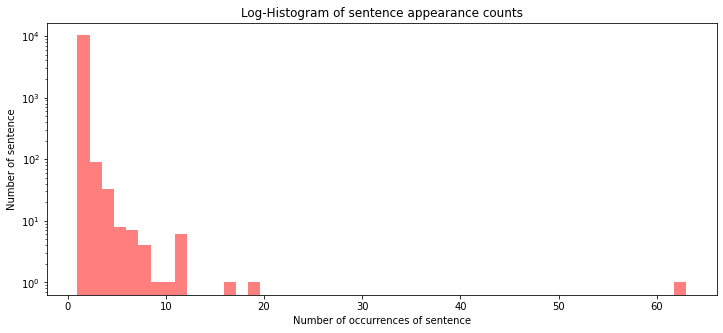

In [12]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(12, 5))
# 히스토그램 선언
# bins: 히스토그램 값들에 대한 버켓 범위
# range: x축 값의 범위
# alpha: 그래프 색상 투명도
# color: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_set.value_counts(), bins=50, alpha=0.5, color= 'r', label='word')
plt.yscale('log', nonposy='clip')
# 그래프 제목
plt.title('Log-Histogram of sentence appearance counts')
# 그래프 x 축 라벨
plt.xlabel('Number of occurrences of sentence')
# 그래프 y 축 라벨
plt.ylabel('Number of sentence')

In [13]:
print('중복 최대 개수: {}'.format(np.max(train_set.value_counts())))
print('중복 최소 개수: {}'.format(np.min(train_set.value_counts())))
print('중복 평균 개수: {:.2f}'.format(np.mean(train_set.value_counts())))
print('중복 표준편차: {:.2f}'.format(np.std(train_set.value_counts())))
print('중복 중간길이: {}'.format(np.median(train_set.value_counts())))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('제 1 사분위 중복: {}'.format(np.percentile(train_set.value_counts(), 25)))
print('제 3 사분위 중복: {}'.format(np.percentile(train_set.value_counts(), 75)))

중복 최대 개수: 63
중복 최소 개수: 1
중복 평균 개수: 1.11
중복 표준편차: 0.81
중복 중간길이: 1.0
제 1 사분위 중복: 1.0
제 3 사분위 중복: 1.0


{'whiskers': [<matplotlib.lines.Line2D at 0x1a2e9e8c88>,
 'caps': [<matplotlib.lines.Line2D at 0x1a2ee21278>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a2e9e8a20>],
 'medians': [<matplotlib.lines.Line2D at 0x1a2ee21828>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a2ee21cf8>],
 'means': [<matplotlib.lines.Line2D at 0x1a2ee21b00>]}

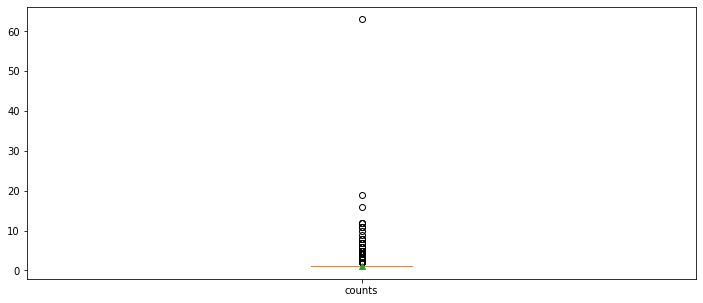

In [14]:
plt.figure(figsize=(12, 5))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를 입력
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 마크함

plt.boxplot([train_set.value_counts()],
             labels=['counts'],
             showmeans=True)

## 문장 길이 분석 (음절 단위)

In [15]:
train_length = train_set.apply(len)

Text(0, 0.5, 'Probability')

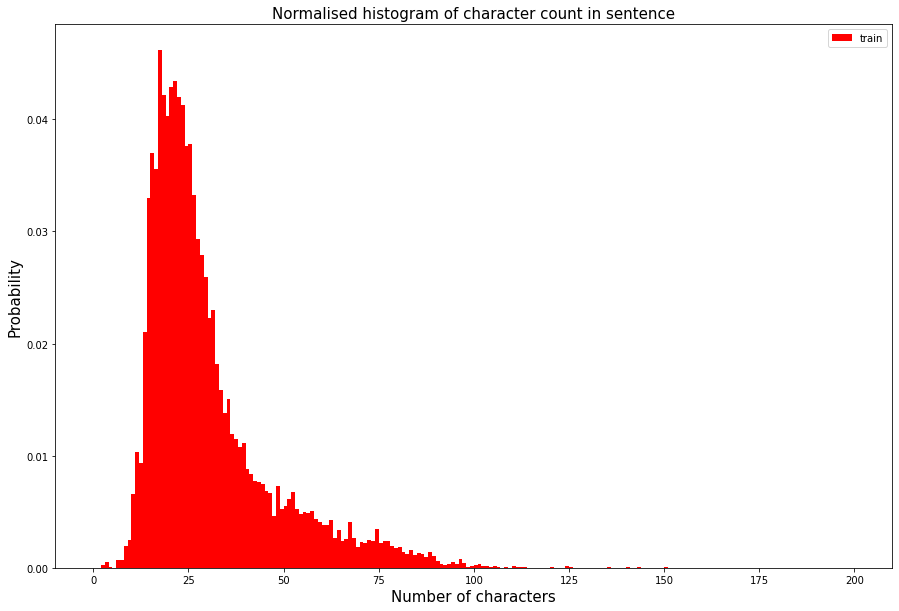

In [16]:
plt.figure(figsize=(15, 10))
plt.hist(train_length, bins=200, range=[0,200], facecolor='r', density=True, label='train')
plt.title("Normalised histogram of character count in sentence", fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

In [17]:
print('문장 길이 최대 값: {}'.format(np.max(train_length)))
print('문장 길이 평균 값: {:.2f}'.format(np.mean(train_length)))
print('문장 길이 표준편차: {:.2f}'.format(np.std(train_length)))
print('문장 길이 중간 값: {}'.format(np.median(train_length)))
print('문장 길이 제 1 사분위: {}'.format(np.percentile(train_length, 25)))
print('문장 길이 제 3 사분위: {}'.format(np.percentile(train_length, 75)))

문장 길이 최대 값: 150
문장 길이 평균 값: 29.80
문장 길이 표준편차: 16.76
문장 길이 중간 값: 25.0
문장 길이 제 1 사분위: 19.0
문장 길이 제 3 사분위: 35.0


{'whiskers': [<matplotlib.lines.Line2D at 0x1a2f6461d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1a2f646780>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a2f63cf28>],
 'medians': [<matplotlib.lines.Line2D at 0x1a2f646d30>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a2f662240>],
 'means': [<matplotlib.lines.Line2D at 0x1a2f662048>]}

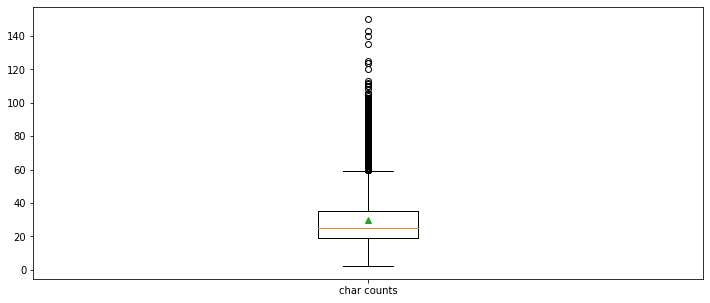

In [18]:
plt.figure(figsize=(12, 5))

plt.boxplot(train_length,
             labels=['char counts'],
             showmeans=True)

## 단어 개수 분석 (띄어쓰기 단위)

In [19]:
train_word_counts = train_set.apply(lambda x:len(x.split(' ')))

Text(0, 0.5, 'Prabability')

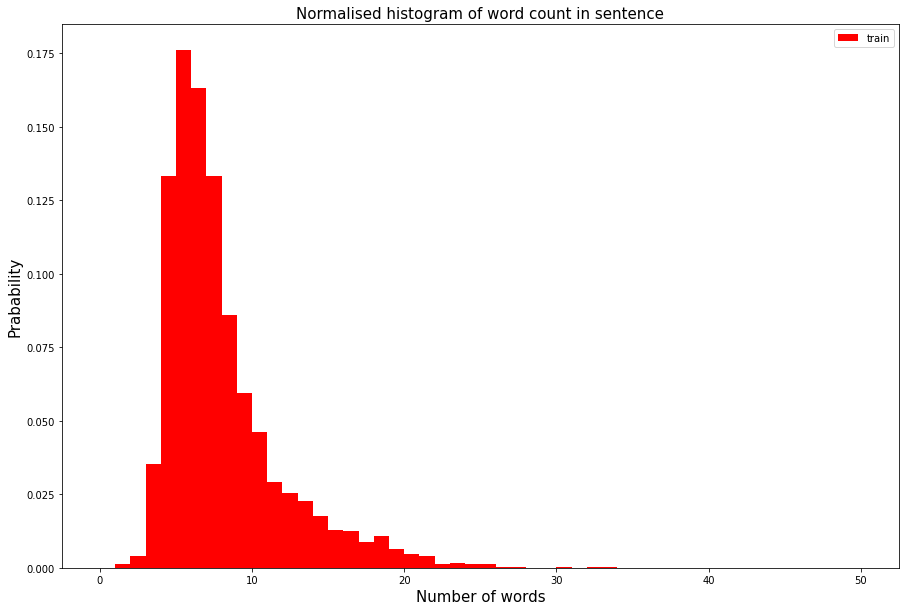

In [20]:
plt.figure(figsize=(15, 10))
plt.hist(train_word_counts, bins=50, range=[0, 50], facecolor='r', density=True, label='train')
plt.title('Normalised histogram of word count in sentence', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Prabability', fontsize=15)

In [21]:
print('문장 단어 개수 최대 값: {}'.format(np.max(train_word_counts)))
print('문장 단어 개수 평균 값: {:.2f}'.format(np.mean(train_word_counts)))
print('문장 단어 개수 표준편차: {:.2f}'.format(np.std(train_word_counts)))
print('문장 단어 개수 중간 값: {}'.format(np.median(train_word_counts)))
print('문장 단어 개수 제 1 사분위: {}'.format(np.percentile(train_word_counts, 25)))
print('문장 단어 개수 제 3 사분위: {}'.format(np.percentile(train_word_counts, 75)))
print('문장 단어 개수 99 퍼센트: {}'.format(np.percentile(train_word_counts, 99)))

문장 단어 개수 최대 값: 33
문장 단어 개수 평균 값: 7.50
문장 단어 개수 표준편차: 3.84
문장 단어 개수 중간 값: 6.0
문장 단어 개수 제 1 사분위: 5.0
문장 단어 개수 제 3 사분위: 9.0
문장 단어 개수 99 퍼센트: 21.0


{'whiskers': [<matplotlib.lines.Line2D at 0x1a2fb794a8>,
 'caps': [<matplotlib.lines.Line2D at 0x1a2fb79a58>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a2fb79240>],
 'medians': [<matplotlib.lines.Line2D at 0x1a2fb88048>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a2fb88518>],
 'means': [<matplotlib.lines.Line2D at 0x1a2fb88320>]}

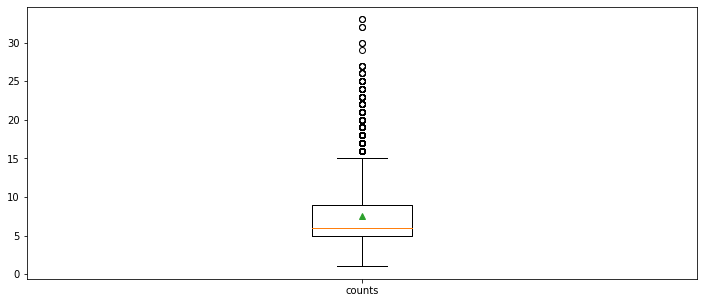

In [22]:
plt.figure(figsize=(12, 5))

plt.boxplot(train_word_counts,
             labels=['counts'],
             showmeans=True)

## 특수 기호 분석

In [26]:
qmarks = np.mean(train_set.apply(lambda x: '?' in x)) # 물음표가 구두점으로 쓰임
math = np.mean(train_set.apply(lambda x: '[math]' in x)) # []
fullstop = np.mean(train_set.apply(lambda x: '.' in x)) # 마침표
capital_first = np.mean(train_set.apply(lambda x: x[0].isupper())) #  첫번째 대문자
capitals = np.mean(train_set.apply(lambda x: max([y.isupper() for y in x]))) # 대문자가 몇개
numbers = np.mean(train_set.apply(lambda x: max([y.isdigit() for y in x]))) # 숫자가 몇개

In [27]:
print('물음표가있는 문장: {:.2f}%'.format(qmarks * 100))
print('마침표를 포함한 문장: {:.2f}%'.format(fullstop * 100))
print('첫 글자가 대문자 인 문장: {:.2f}%'.format(capital_first * 100))
print('대문자가있는 문장: {:.2f}%'.format(capitals * 100))
print('숫자가있는 문장: {:.2f}%'.format(numbers * 100))

물음표가있는 문장: 1.81%
마침표를 포함한 문장: 70.13%
첫 글자가 대문자 인 문장: 1.84%
대문자가있는 문장: 5.84%
숫자가있는 문장: 19.33%


## 버트 토크나이징 분석

In [28]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)


Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

In [29]:
# 버트 토큰 개수
train_bert_token_counts = train_set.apply(lambda x:len(tokenizer.tokenize(x)))

Text(0, 0.5, 'Prabability')

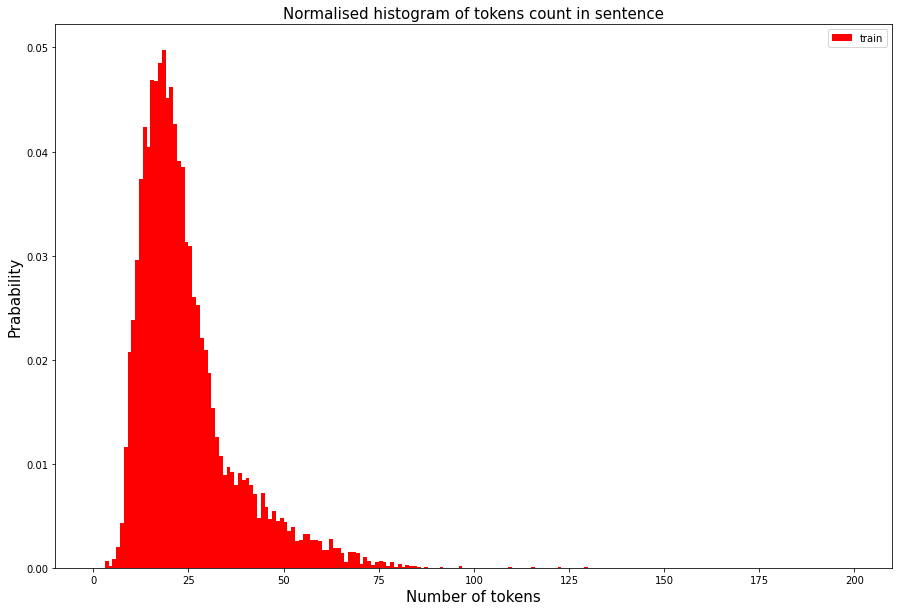

In [30]:
plt.figure(figsize=(15, 10))
plt.hist(train_bert_token_counts, bins=200, range=[0, 200], facecolor='r', density=True, label='train')
plt.title('Normalised histogram of tokens count in sentence', fontsize=15)
plt.legend()
plt.xlabel('Number of tokens', fontsize=15)
plt.ylabel('Prabability', fontsize=15)

In [31]:
print('문장 tokens 개수 최대 값: {}'.format(np.max(train_bert_token_counts)))
print('문장 tokens 개수 평균 값: {:.2f}'.format(np.mean(train_bert_token_counts)))
print('문장 tokens 개수 표준편차: {:.2f}'.format(np.std(train_bert_token_counts)))
print('문장 tokens 개수 중간 값: {}'.format(np.median(train_bert_token_counts)))
print('문장 tokens 개수 제 1 사분위: {}'.format(np.percentile(train_bert_token_counts, 25)))
print('문장 tokens 개수 제 3 사분위: {}'.format(np.percentile(train_bert_token_counts, 75)))
print('문장 tokens 개수 99 퍼센트: {}'.format(np.percentile(train_bert_token_counts, 99)))

문장 tokens 개수 최대 값: 129
문장 tokens 개수 평균 값: 23.84
문장 tokens 개수 표준편차: 12.68
문장 tokens 개수 중간 값: 21.0
문장 tokens 개수 제 1 사분위: 15.0
문장 tokens 개수 제 3 사분위: 28.0
문장 tokens 개수 99 퍼센트: 67.0


{'whiskers': [<matplotlib.lines.Line2D at 0x1a2fd87978>,
 'caps': [<matplotlib.lines.Line2D at 0x1a2fd87f28>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a2fd87710>],
 'medians': [<matplotlib.lines.Line2D at 0x1a2fd98518>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a2fd989e8>],
 'means': [<matplotlib.lines.Line2D at 0x1a2fd987f0>]}

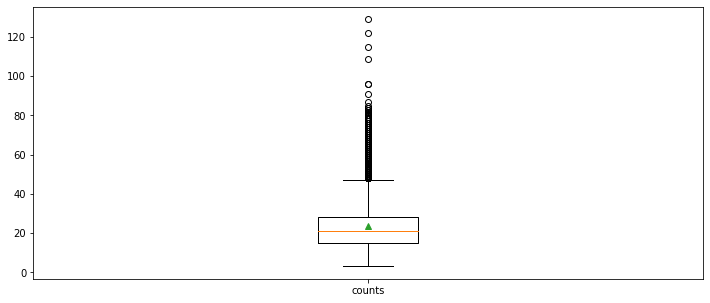

In [32]:
plt.figure(figsize=(12, 5))

plt.boxplot(train_bert_token_counts,
             labels=['counts'],
             showmeans=True)

In [33]:
# do_lower_case = False
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

In [34]:
train_bert_token_cased_counts = train_set.apply(lambda x:len(tokenizer.tokenize(x)))


Text(0, 0.5, 'Prabability')

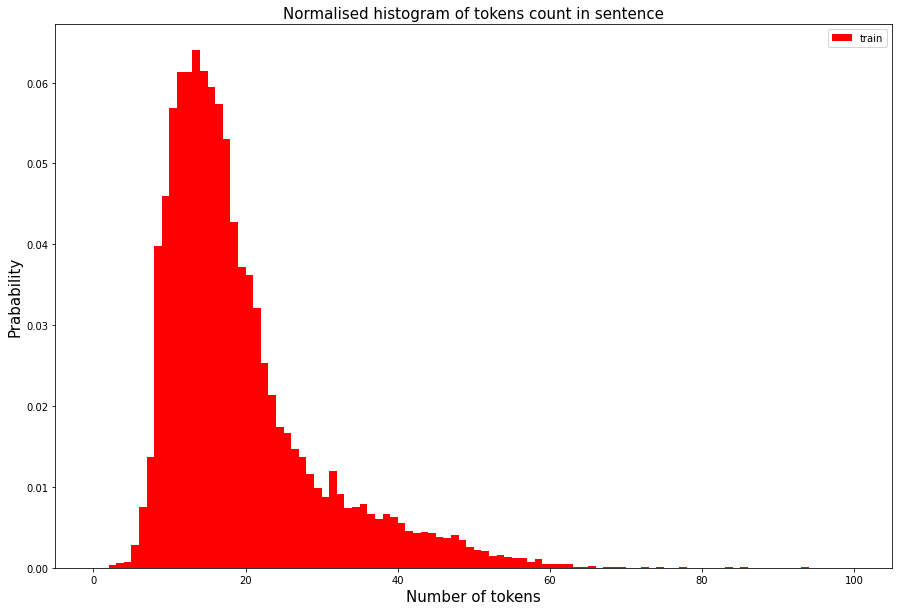

In [35]:
plt.figure(figsize=(15, 10))
plt.hist(train_bert_token_cased_counts, bins=100, range=[0, 100], facecolor='r', density=True, label='train')
plt.title('Normalised histogram of tokens count in sentence', fontsize=15)
plt.legend()
plt.xlabel('Number of tokens', fontsize=15)
plt.ylabel('Prabability', fontsize=15)

In [36]:
print('문장 tokens 개수 최대 값: {}'.format(np.max(train_bert_token_cased_counts)))
print('문장 tokens 개수 평균 값: {:.2f}'.format(np.mean(train_bert_token_cased_counts)))
print('문장 tokens 개수 표준편차: {:.2f}'.format(np.std(train_bert_token_cased_counts)))
print('문장 tokens 개수 중간 값: {}'.format(np.median(train_bert_token_cased_counts)))
print('문장 tokens 개수 제 1 사분위: {}'.format(np.percentile(train_bert_token_cased_counts, 25)))
print('문장 tokens 개수 제 3 사분위: {}'.format(np.percentile(train_bert_token_cased_counts, 75)))
print('문장 tokens 개수 99 퍼센트: {}'.format(np.percentile(train_bert_token_cased_counts, 99)))

문장 tokens 개수 최대 값: 102
문장 tokens 개수 평균 값: 18.74
문장 tokens 개수 표준편차: 10.12
문장 tokens 개수 중간 값: 16.0
문장 tokens 개수 제 1 사분위: 12.0
문장 tokens 개수 제 3 사분위: 22.0
문장 tokens 개수 99 퍼센트: 53.0


{'whiskers': [<matplotlib.lines.Line2D at 0x1a30ca5438>,
 'caps': [<matplotlib.lines.Line2D at 0x1a30ca59e8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a30ca51d0>],
 'medians': [<matplotlib.lines.Line2D at 0x1a30ca5f98>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a30c984a8>],
 'means': [<matplotlib.lines.Line2D at 0x1a30c982b0>]}

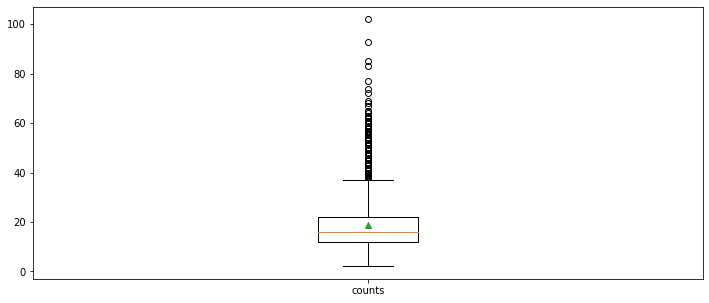

In [37]:
plt.figure(figsize=(12, 5))

plt.boxplot(train_bert_token_cased_counts,
             labels=['counts'],
             showmeans=True)


## 어휘 분석

(-0.5, 799.5, 599.5, -0.5)

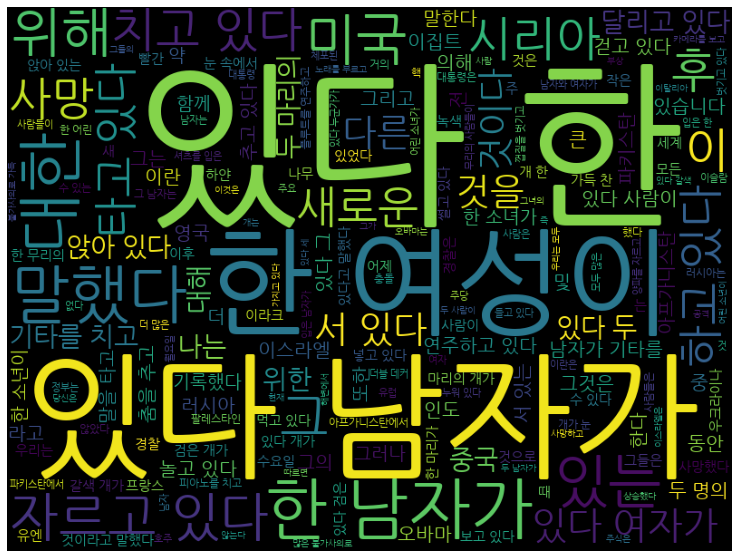

In [38]:
from wordcloud import WordCloud

font_path = os.path.join(DATA_IN_PATH, 'NanumGothic.ttf')
cloud = WordCloud(font_path = font_path, width=800, height=600).generate(" ".join(train_set.astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

## 장르, 파일이름, 연도 분석

<AxesSubplot:>

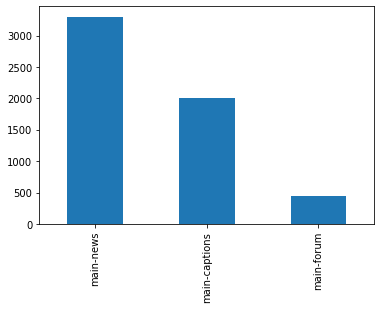

In [41]:
train_data.genre.value_counts().plot(kind='bar')

<AxesSubplot:>

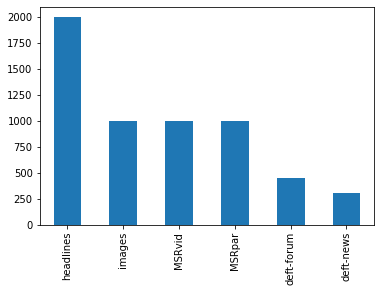

In [42]:
train_data.filename.value_counts().plot(kind='bar')

<AxesSubplot:>

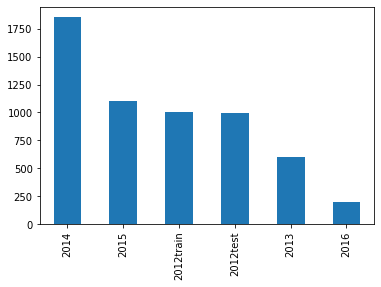

In [43]:
train_data.year.value_counts().plot(kind='bar')

<AxesSubplot:>

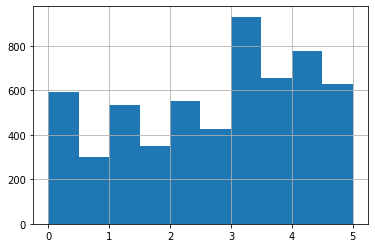

In [44]:
train_data.score.hist()